<a href="https://colab.research.google.com/github/imsewonyyy/AI-/blob/main/%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8%EB%A7%81_%EB%AA%A8%EB%8D%B8%EB%A7%81_%EB%B0%8F_%ED%8F%89%EA%B0%80_%EA%B9%80%EC%9D%98%EB%8F%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.67      0.52      0.58        58
           1       0.81      0.89      0.85       136

    accuracy                           0.78       194
   macro avg       0.74      0.70      0.72       194
weighted avg       0.77      0.78      0.77       194

ROC-AUC: 0.7969066937119675
Average Precision (PR AUC): 0.8866638875185519
Cross-Validation ROC-AUC: 0.7624902998236333

=== Random Forest ===
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.71      0.41      0.52        58
           1       0.79      0.93      0.85       136

    accuracy                           0.77       194
   macro avg       0.75      0.67      0.69       194
weighted avg       0.76      0.77      0.75       194

ROC-AUC: 0.8100912778904665
Average Precision (PR AUC): 0.9109518345539882


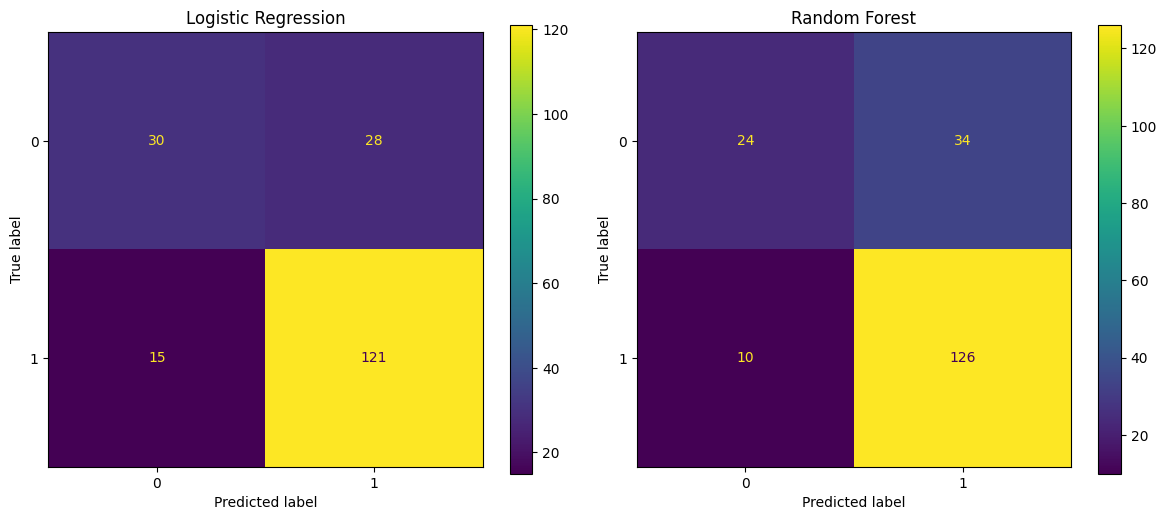

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve
)

# 1. 데이터 불러오기
df = pd.read_csv("GermanCredit_simple_garbled.csv")

# 2. 불필요한 열 제거
df.drop(columns=["OBS#"], inplace=True, errors="ignore")

# 3. amount가 음수인 행 제거
df = df[df["AMOUNT"] >= 0]

# 4. 결측치 처리 (수치형은 중앙값으로 대체)
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 5. 범주형 변수 원-핫 인코딩
df = pd.get_dummies(df, drop_first=True)

# 6. X, y 분리
X = df.drop("RESPONSE", axis=1)
y = df["RESPONSE"]

# 7. 데이터 분할
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# 8. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 9. 로지스틱 회귀 모델
log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_scaled, y_train)
log_preds = log_clf.predict(X_test_scaled)
log_proba = log_clf.predict_proba(X_test_scaled)[:, 1]

# 교차검증 (Stratified K-Fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_cv_score = cross_val_score(log_clf, X_train_scaled, y_train, cv=cv, scoring="roc_auc").mean()

print("=== Logistic Regression ===")
print(classification_report(y_test, log_preds))
print("ROC-AUC:", roc_auc_score(y_test, log_proba))
print("Average Precision (PR AUC):", average_precision_score(y_test, log_proba))
print("Cross-Validation ROC-AUC:", log_cv_score)

# 10. 랜덤 포레스트 + 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
rf_preds = best_rf.predict(X_test)
rf_proba = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print("Best Parameters:", rf_grid.best_params_)
print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_proba))
print("Average Precision (PR AUC):", average_precision_score(y_test, rf_proba))

# 11. 혼동 행렬 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, log_preds)).plot(ax=axes[0])
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(confusion_matrix(y_test, rf_preds)).plot(ax=axes[1])
axes[1].set_title("Random Forest")
plt.tight_layout()
plt.show()


해당 모델링을 진행하면서 중요한 가정

1: 신용 우량자

0: 신용 불량자

비용이 큰 오류:
▶ 실제 0 (불량자)를 1 (우량자)로 잘못 예측 → False Positive (FP)
→ 예: 대출해줬는데 돈을 못 갚음 → 금전적 손실 큼

비용이 적은 오류:
▶ 실제 1 (우량자)를 0 (불량자)로 판단 → False Negative (FN)
→ 우량자를 거절한 경우 → 손해는 있지만 상대적으로 작음

| 지표                | Logistic Regression | Random Forest |
| ----------------- | ------------------- | ------------- |
| **정확도**           | 0.78                | 0.77          |
| **Precision (0)** | 0.67                | **0.71** ✅    |
| **Recall (0)**    | **0.52** ✅          | 0.41          |
| **F1-score (0)**  | **0.58** ✅          | 0.52          |
| **ROC-AUC**       | 0.797               | **0.810** ✅   |
| **PR AUC**        | 0.887               | **0.911** ✅   |

🔍 핵심 비교: “불량자를 우량자로 오판(FP)” 줄이기
모델	FP (False Positive, 0 → 1)
Logistic	28명 ✅ 더 적음
Random Forest	34명 → 더 많음 ❌

→ 따라서, Logistic Regression이 불량자(Fraud)를 더 잘 걸러냅니다.

FP의 기회비용이 FN의 기회비용보다 크기에 해당 관점에서만 본다면 로지스틱 분석이 더 나은 모델이 될 수 있다. 이는 RECALL값이 로지스틱 분석이 더 크기때문이다.
그러나 위의 결과에서 보이듯 다른 요소에서는 랜덤포레스트가 더 나은 결과를 보여주기에 실제 이를 적용할 때에는 FP와 FN의 비용의 차이를 정확하게 반영되어야 할 것이다.

In [ ]:
# 12. 특성 중요도
# 로지스틱 회귀 계수
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_clf.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nTop 10 Positive Coefficients in Logistic Regression:")
print(coef_df.head(10))
print("\nTop 10 Negative Coefficients in Logistic Regression:")
print(coef_df.tail(10))

# 랜덤 포레스트 특성 중요도
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Feature Importances in Random Forest:")
print(feat_imp.head(10))



Top 10 Positive Coefficients in Logistic Regression:
        Feature  Coefficient
0      CHK_ACCT     0.659953
2       HISTORY     0.525674
10     SAV_ACCT     0.375088
29      FOREIGN     0.262679
21          AGE     0.246066
17    GUARANTOR     0.212399
28    TELEPHONE     0.186869
14  MALE_SINGLE     0.167148
4      USED_CAR     0.149155
8    RETRAINING     0.074502

Top 10 Negative Coefficients in Logistic Regression:
            Feature  Coefficient
15  MALE_MAR_or_WID    -0.135642
7         EDUCATION    -0.170437
23             RENT    -0.195926
16     CO-APPLICANT    -0.241406
20   PROP_UNKN_NONE    -0.244580
13         MALE_DIV    -0.259392
22    OTHER_INSTALL    -0.307685
3           NEW_CAR    -0.356398
9            AMOUNT    -0.396252
12     INSTALL_RATE    -0.502844

Top 10 Feature Importances in Random Forest:
             Feature  Importance
0           CHK_ACCT    0.120910
9             AMOUNT    0.116119
21               AGE    0.104713
1           DURATION    0.083880

위의 두 순위는 제목에서 알 수 있듯, 로지스틱 회귀 분석시 영향을 주는 요소들이다.

| 순위 | 변수명                                                                 | 계수     | 해석                                |
| -- | ------------------------------------------------------------------- | ------ | --------------------------------- |
| 1  | `CHK_ACCT`                                                          | 0.6599 | **당좌 예금 유무** → 예금 많으면 우량자로 판단     |
| 2  | `HISTORY`                                                           | 0.5257 | **신용 이력** → 길고 좋은 이력 = 우량자        |
| 3  | `SAV_ACCT`                                                          | 0.3751 | **저축 예금 유무** → 많을수록 우량자           |
| 4  | `FOREIGN`                                                           | 0.2627 | 외국인 여부 → 외국인이 우량자일 가능성 높음 (예측의사?) |
| 5  | `AGE`                                                               | 0.2461 | 나이 많을수록 신용도 ↑                     |
| …  | `GUARANTOR`, `TELEPHONE`, `MALE_SINGLE`, `USED_CAR`, `RETRAINING` 등 |        |                                   |


| 순위 | 변수명                                   | 계수      | 해석                    |
| -- | ------------------------------------- | ------- | --------------------- |
| 1  | `INSTALL_RATE`                        | -0.5028 | **할부 이자율** ↑ → 신용 ↓   |
| 2  | `AMOUNT`                              | -0.3963 | **대출 금액** ↑ → 상환 위험 ↑ |
| 3  | `NEW_CAR`                             | -0.3564 | 신차 구매 = 대출 위험 ↑       |
| 4  | `OTHER_INSTALL`                       | -0.3077 | 다른 할부 계약 있음 = 부담 ↑    |
| 5  | `MALE_DIV`                            | -0.2594 | 남성 이혼자 → 위험군          |
| …  | `CO-APPLICANT`, `RENT`, `EDUCATION` 등 |         |                       |


| 순위 | 변수명                | 중요도   | 해석              |
| -- | ------------------ | ----- | --------------- |
| 1  | `CHK_ACCT`         | 0.121 | 당좌예금 잔액 → 핵심 변수 |
| 2  | `AMOUNT`           | 0.116 | 대출 금액           |
| 3  | `AGE`              | 0.105 | 나이              |
| 4  | `DURATION`         | 0.084 | 대출 기간           |
| 5  | `HISTORY`          | 0.070 | 신용 이력           |
| 6  | `EMPLOYMENT`       | 0.049 | 고용 상태           |
| 7  | `INSTALL_RATE`     | 0.042 | 할부 비율           |
| 8  | `PRESENT_RESIDENT` | 0.037 | 거주기간            |
| 9  | `SAV_ACCT`         | 0.037 | 저축 잔고           |
| 10 | `JOB`              | 0.029 | 직업 등급           |


로지스틱 회귀와 랜덤포레스트를 비교하였을 때 CHK_ACCT, AMOUNT, AGE, HISTORY의 항목은 공통적으로 큰 영향을 주는 것을 파악할 수 있음

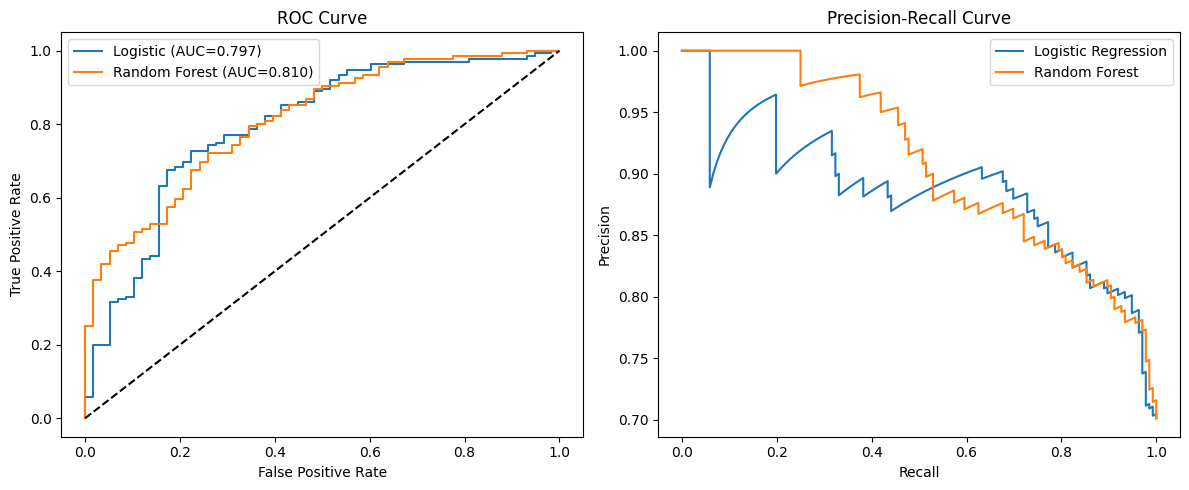

In [ ]:
# 13. PR Curve & ROC Curve
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, log_proba)
plt.plot(fpr, tpr, label="Logistic (AUC={:.3f})".format(roc_auc_score(y_test, log_proba)))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (AUC={:.3f})".format(roc_auc_score(y_test, rf_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, log_proba)
plt.plot(recall, precision, label="Logistic Regression")
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_proba)
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


ROC Curve에서 두 모델 모두 거의 비슷한 양상을 보여줌

| 축            | 의미                                       |
| ------------ | ---------------------------------------- |
| **X축 (FPR)** | False Positive Rate: 실제 0인데 1로 예측한 비율    |
| **Y축 (TPR)** | True Positive Rate = Recall: 실제 1을 맞춘 비율 |

RP Curve에서는 랜덤포레스트가 조금 더 우세한 모습을 보인다. 즉, 우량자를 더 잘 잡아낸다.

| 지표            | 정의                                                      |
| ------------- | ------------------------------------------------------- |
| **Precision** | `TP / (TP + FP)` → **예측한 1 중 실제로 1인 비율**                |
| **Recall**    | `TP / (TP + FN)` → **실제 1 중 맞춘 비율** (**= Sensitivity**) |

